#Library

In [1]:
import re 
import pickle 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model


# **Prepare datasets**

In [2]:
df= pd.read_csv('train_preprocess.tsv', sep='\t', header=None)

In [3]:
df.head()

,0,1
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
df.shape

(11000, 2)

In [5]:
df.columns =['text', 'label']
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


#Check Data

In [6]:
fig = px.pie(df, names='label', title ='Pie chart of different sentiments')
fig.show()

Kita cek isi datasetnya dan di dalamnya terdapat 11000 data. Terdiri dari:


*   Positive: 6416
*   Neutral: 1148
*   Negative: 3436



In [7]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

#Dataset Under Sampling

In [8]:
df_positive = df[df['label']=='positive']
df_negative = df[df['label']=='negative']
df_neutral = df[df['label']=='neutral']

In [9]:
df_positive.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
5,"makanan beragam , harga makanan di food stall ...",positive
7,"tempat unik , bagus buat foto , makanan enak ,...",positive


In [12]:
df_negative.head()

,text,label
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
6,pakai kartu kredit bca tidak untung malah rugi...,negative
10,simcard indosat inaktiv gara-gara lupa isi pul...,negative
11,sifat iri sering muncul pada orang orang yang ...,negative
13,"pengalaman bersama indosat hari ini , semoga t...",negative


In [13]:
df_down_positive = df_positive.sample(1148)

In [14]:
df_down_negative = df_negative.sample(1148)

In [15]:
df_undersampling = pd.concat([df_down_positive,df_down_negative, df_neutral])
df_undersampling

,text,label
1666,"ribuan menu ada di sini ! tinggal pilih , pesa...",positive
1631,resto ini salah satu kesukaan saya kalau lagi ...,positive
1609,sate kambing ini rasanya beda dengan tempat la...,positive
8921,dulu awal ke warung mi ini secara tidak sengaj...,positive
1061,tidak kesal,positive
...,...,...
10925,pkb benarkan charly setia band daftar jadi caw...,neutral
10967,pernah percaya kalau body lotion citra bikin b...,neutral
10969,"bu susi marah , menteri luhut perbolehkan kapa...",neutral
10993,f - demokrat dorong upaya kemandirian energi n...,neutral


In [17]:
df = df_undersampling

In [18]:
fig = px.pie(df, names='label', title ='Pie chart of different sentiments')
fig.show()

In [35]:
df.label.value_counts()

positive    1148
negative    1148
neutral     1148
Name: label, dtype: int64

# **Text Normalization/Cleansing**

Cleansing data (sumber dari challenge sebelumnya)

In [19]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

#merubah kata kata alay menjadi kata kata baku
#def normalize_alay(text):
    #return ' '.join([data_alay_new_map[word] if word in data_alay_new_map else word for word in text.split(' ')])
def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    #text = normalize_alay(text) # 3
    return text


In [20]:
df['text_clean'] = df.text.apply(preprocess)

In [22]:
df

,text,label,text_clean
1666,"ribuan menu ada di sini ! tinggal pilih , pesa...",positive,ribuan menu ada di sini tinggal pilih pesan ba...
1631,resto ini salah satu kesukaan saya kalau lagi ...,positive,resto ini salah satu kesukaan saya kalau lagi ...
1609,sate kambing ini rasanya beda dengan tempat la...,positive,sate kambing ini rasanya beda dengan tempat la...
8921,dulu awal ke warung mi ini secara tidak sengaj...,positive,dulu awal ke warung mi ini secara tidak sengaj...
1061,tidak kesal,positive,tidak kesal
...,...,...,...
10925,pkb benarkan charly setia band daftar jadi caw...,neutral,pkb benarkan charly setia band daftar jadi caw...
10967,pernah percaya kalau body lotion citra bikin b...,neutral,pernah percaya kalau body lotion citra bikin b...
10969,"bu susi marah , menteri luhut perbolehkan kapa...",neutral,bu susi marah menteri luhut perbolehkan kapal ...
10993,f - demokrat dorong upaya kemandirian energi n...,neutral,f demokrat dorong upaya kemandirian energi nas...


#Sortir Data Berdasarkan 3 Sentimen

In [23]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('Pos: %s, Neu: %s, Neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(total_data))


Pos: 1148, Neu: 1148, Neg: 1148
Total data: 3444


#Feature Extraction

In [24]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('tokenizer.pickle has created!')

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [25]:
X

array([[    0,     0,     0, ...,   156,  2476,     1],
       [    0,     0,     0, ...,     1,    16,    10],
       [    0,     0,     0, ...,     7,  1384,    10],
       ...,
       [    0,     0,     0, ..., 10059, 10060,     1],
       [    0,     0,     0, ...,    81,  3194,    30],
       [    0,     0,     0, ...,    42,  2049,   224]], dtype=int32)

In [26]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

y_labels.pickle has created!


In [27]:
Y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

#Split Dataset For Training & Testing

In [28]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Training (LSTM)

In [29]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
276/276 [==============================] - 10s 14ms/step - loss: 0.7124 - accuracy: 0.6889 - val_loss: 0.5079 - val_accuracy: 0.8113
Epoch 2/10
276/276 [==============================] - 3s 12ms/step - loss: 0.3066 - accuracy: 0.8976 - val_loss: 0.4710 - val_accuracy: 0.8447
Epoch 3/10
276/2

#Evaluation

In [30]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai')
print(matrix_test)

22/22 [==============================] - 0s 3ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       232
           1       0.78      0.87      0.82       218
           2       0.81      0.80      0.81       239

    accuracy                           0.79       689
   macro avg       0.79      0.79      0.79       689
weighted avg       0.79      0.79      0.79       689



#Cross Validation

In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)


Epoch 1/10
880/880 [==============================] - 13s 14ms/step - loss: 0.4550 - accuracy: 0.8173 - val_loss: 0.3353 - val_accuracy: 0.8800
Epoch 2/10
880/880 [==============================] - 11s 12ms/step - loss: 0.2019 - accuracy: 0.9272 - val_loss: 0.3413 - val_accuracy: 0.8709
Epoch 3/10
880/880 [==============================] - 11s 13ms/step - loss: 0.1044 - accuracy: 0.9589 - val_loss: 0.4135 - val_accuracy: 0.8655
Epoch 4/10
880/880 [==============================] - 11s 13ms/step - loss: 0.0659 - accuracy: 0.9756 - val_loss: 0.4595 - val_accuracy: 0.8718
Epoch 5/10
880/880 [==============================] - 11s 13ms/step - loss: 0.0388 - accuracy: 0.9858 - val_loss: 0.5611 - val_accuracy: 0.8664
Epoch 6/10
880/880 [==============================] - 11s 13ms/step - loss: 0.0308 - accuracy: 0.9908 - val_loss: 0.5937 - val_accuracy: 0.8673
Epoch 7/10
880/880 [==============================] - 11s 13ms/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.6668 - val_accuracy:

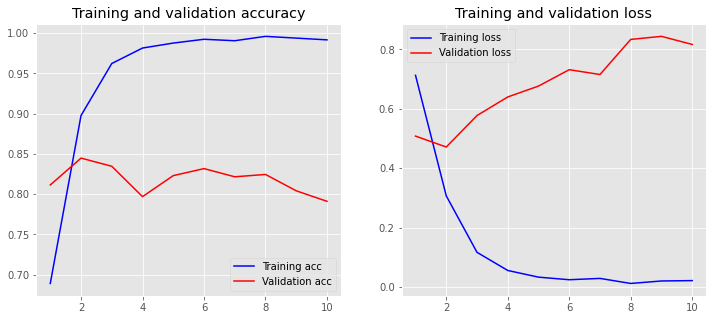

In [31]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) +1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline
plot_history(history)
  

#Export Model

In [32]:
model.save('model.h5')
print('Model has created!')

Model has created!


#Testing Model

In [34]:
input_text = """ 
tidak bersyukur..,,;,;
"""

sentiment = ['negative', 'neutral', 'positive']

text = [preprocess(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 0s 349ms/step
Text:   tidak bersyukur 
Sentiment:  positive
